In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from data_process import tokenizers, utils
from nanoGPT.model import  GPT, GPTConfig
from lightning_training import LightningGPT, GamesDataModule, GamesDataset
import pytorch_lightning as pl
import torch
import os
import numpy as np
import seaborn as sns

In [4]:
headers = ["index", "id", "date", "white_elo", "black_elo", "result", "ply", "ply_30s", "piece_uci"]

games_df = pd.read_csv("./data/csv/uniform_elo_distribution/test.csv", delimiter=";", header=None, names=headers)

games_df['piece_uci'] = utils.remove_material_tokens(games_df['piece_uci'])

games_df

,index,id,date,white_elo,black_elo,result,ply,ply_30s,piece_uci
0,74497,?,2021.12.05,2523,2684,0-1,52,-1,Pd2d4 Pd7d5 Nb1c3 Pc7c6 Pe2e4 Pd5e4 Pf2f3 Pe4f...
1,74505,?,2021.12.05,2623,2581,0-1,96,-1,Pd2d4 Ng8f6 Pc2c4 Pe7e6 Ng1f3 Pd7d5 Nb1c3 Pd5c...
2,74508,?,2021.12.05,2757,2670,1/2-1/2,106,-1,Pd2d4 Pd7d5 Ke1d2 Pe7e5 Kd2c3 Pe5d4 Qd1d4 Nb8c...
3,74510,?,2021.12.05,2627,2666,0-1,96,-1,Pd2d4 Ng8f6 Bc1f4 Pd7d5 Pe2e3 Pe7e6 Pc2c3 Bf8d...
4,74517,?,2021.12.05,2666,2571,1-0,47,-1,Pe2e4 Pc7c5 Ng1f3 Nb8c6 Bf1b5 Pg7g6 Bb5c6 Pd7c...
...,...,...,...,...,...,...,...,...,...
99995,14202188,CJayVtXh,2024.12.05,1303,879,1-0,33,-1,Pe2e4 Pe7e6 Ng1f3 Pf7f6 Bf1c4 Qd8e7 Ke1g1 Ng8h...
99996,14202189,XkroYjvj,2024.12.05,1099,1209,0-1,59,-1,Pe2e4 Pe7e5 Ng1f3 Nb8c6 Pd2d4 Pd7d6 Pd4e5 Bc8g...
99997,14202191,DWLSh6Wn,2024.12.05,1070,1019,0-1,48,-1,Pe2e4 Pe7e5 Ng1f3 Ng8f6 Nb1c3 Nb8c6 Bf1c4 Bf8c...
99998,14202194,g7tUv4Rt,2024.12.05,1211,1173,1-0,9,-1,Pe2e4 Pd7d5 Bf1c4 Pe7e5 Bc4d5 Nb8d7 Qd1h5 Ng8f...


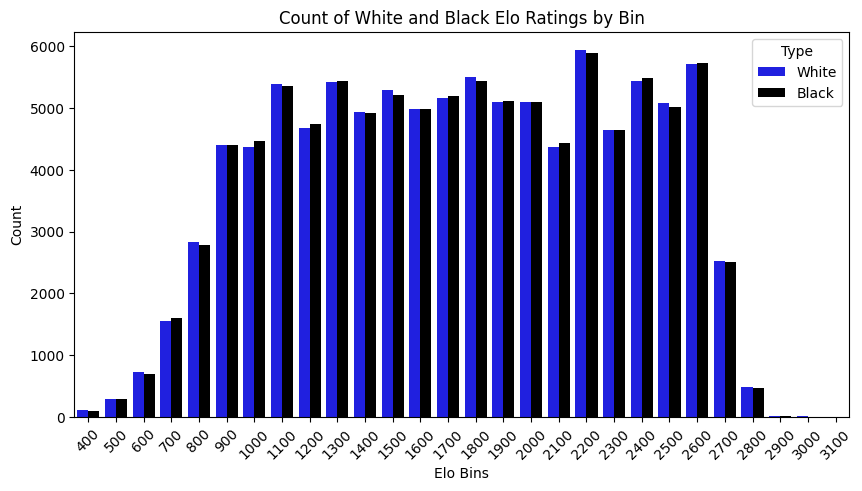

In [5]:
white_elo_bins = games_df.white_elo // 100 * 100
black_elo_bins = games_df.black_elo // 100 * 100

data = pd.DataFrame({
    'Elo Bin': list(white_elo_bins) + list(black_elo_bins),
    'Type': ['White'] * len(white_elo_bins) + ['Black'] * len(black_elo_bins)
})

plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Elo Bin', hue='Type', palette=['blue', 'black'])
plt.xticks(rotation=45)
plt.xlabel("Elo Bins")
plt.ylabel("Count")
plt.title("Count of White and Black Elo Ratings by Bin")
plt.show()

In [4]:
tokenizer = tokenizers.FullMoveTokenizerWithElo()

model_config = GPTConfig(
    block_size=302,
    vocab_size=tokenizer.vocab_size,
    n_layer=8,
    n_head=8,
    n_embd=512,
    bias=False,
)

test_start_token = 1

masked_elo_checkpoint = "./models/masked_elo_training/epoch=9-step=1250000.ckpt"
elo_checkpoint = "./models/adaptive_elo_training/epoch=9-step=1250000.ckpt"

masked_elo_model = LightningGPT.load_from_checkpoint(masked_elo_checkpoint, config=model_config, test_start_token=test_start_token)
elo_model = LightningGPT.load_from_checkpoint(elo_checkpoint, config=model_config, test_start_token=test_start_token)

number of parameters: 27.29M
number of parameters: 27.29M


In [6]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    callbacks=[pl.callbacks.RichProgressBar()],
    precision="bf16-mixed",
)
torch.set_float32_matmul_precision('high')

Using bfloat16 Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
cuts = games_df.ply_30s
games_with_elo = utils.add_elo_token_to_games(games_df.piece_uci, games_df.white_elo, games_df.black_elo)
games_with_elo

0        2500 2600 Pd2d4 Pd7d5 Nb1c3 Pc7c6 Pe2e4 Pd5e4 ...
1        2600 2500 Pd2d4 Ng8f6 Pc2c4 Pe7e6 Ng1f3 Pd7d5 ...
2        2700 2600 Pd2d4 Pd7d5 Ke1d2 Pe7e5 Kd2c3 Pe5d4 ...
3        2600 2600 Pd2d4 Ng8f6 Bc1f4 Pd7d5 Pe2e3 Pe7e6 ...
4        2600 2500 Pe2e4 Pc7c5 Ng1f3 Nb8c6 Bf1b5 Pg7g6 ...
                               ...                        
99995    1300 800 Pe2e4 Pe7e6 Ng1f3 Pf7f6 Bf1c4 Qd8e7 K...
99996    1000 1200 Pe2e4 Pe7e5 Ng1f3 Nb8c6 Pd2d4 Pd7d6 ...
99997    1000 1000 Pe2e4 Pe7e5 Ng1f3 Ng8f6 Nb1c3 Nb8c6 ...
99998    1200 1100 Pe2e4 Pd7d5 Bf1c4 Pe7e5 Bc4d5 Nb8d7 ...
99999    1200 1100 Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb1c3 Qd5d8 ...
Length: 100000, dtype: object

In [10]:
elo_data_module = GamesDataModule(test_games=list(games_with_elo), tokenizer=tokenizer, num_workers=12)

In [ ]:
trainer.test(masked_elo_model, datamodule=elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5107116103172302     │
│         test_loss         │    1.7678557634353638     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7678557634353638, 'test_acc': 0.5107116103172302}]

In [ ]:
masked_elo_model = LightningGPT.load_from_checkpoint(masked_elo_checkpoint, config=model_config, test_start_token=11)

number of parameters: 27.29M


In [ ]:
trainer.test(masked_elo_model, datamodule=elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5110811591148376     │
│         test_loss         │    1.7678557634353638     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7678557634353638, 'test_acc': 0.5110811591148376}]

In [11]:
trainer.test(elo_model, datamodule=elo_data_module)

2025-03-22 12:56:09.778917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742644569.853965   16263 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742644569.874195   16263 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 12:56:10.062748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5142906904220581     │
│         test_loss         │     1.623957633972168     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.623957633972168, 'test_acc': 0.5142906904220581}]

In [13]:
elo_model = LightningGPT.load_from_checkpoint(elo_checkpoint, config=model_config, test_start_token=11)

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    callbacks=[pl.callbacks.RichProgressBar()],
    precision="bf16-mixed",
)
torch.set_float32_matmul_precision('high')

Using bfloat16 Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


number of parameters: 27.29M


In [14]:
trainer.test(elo_model, datamodule=elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.512260377407074     │
│         test_loss         │     1.623957633972168     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.623957633972168, 'test_acc': 0.512260377407074}]